<a href="https://colab.research.google.com/github/fjadidi2001/Image_Inpaint/blob/main/FastInpaintingNet-Jan25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import time

In [38]:
class InpaintingNet(nn.Module):
    def __init__(self):
        super(InpaintingNet, self).__init__()

        # Encoder
        self.encoder1 = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )
        self.encoder2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )
        self.encoder3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )

        # Middle (Bottleneck)
        self.middle = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )

        self.decoder3 = nn.Sequential(
            nn.ConvTranspose2d(512, 128, kernel_size=4, stride=2, padding=1),  # Output: 128 channels
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(192, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )

        # Final output layer
        self.final = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x, mask):
        # Concatenate input image and mask
        x = torch.cat([x, mask], dim=1)

        # Encoder
        e1 = self.encoder1(x)  # Output size: (batch, 64, H/2, W/2)
        e2 = self.encoder2(e1)  # Output size: (batch, 128, H/4, W/4)
        e3 = self.encoder3(e2)  # Output size: (batch, 256, H/8, W/8)

        # Middle
        m = self.middle(e3)  # Output size: (batch, 512, H/8, W/8)

        # Decoder with skip connections
        d3 = self.decoder3(m)  # Output size: (batch, 256, H/4, W/4)
        d3 = torch.cat([d3, e2], dim=1)  # Skip connection (batch, 256 + 128, H/4, W/4)

        d2 = self.decoder2(d3)  # Output size: (batch, 128, H/2, W/2)
        d2 = torch.cat([d2, e1], dim=1)  # Skip connection (batch, 128 + 64, H/2, W/2)

        d1 = self.decoder1(d2)  # Output size: (batch, 64, H, W)

        # Final output
        out = self.final(d1)  # Output size: (batch, 3, H, W)
        return torch.tanh(out)  # Normalize output to [-1, 1]

In [31]:
def setup_data(root_dir='./data', img_size=128, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Load CIFAR-10 dataset
    dataset = datasets.CIFAR10(root=root_dir, train=True, download=True, transform=transform)

    # Split into train, validation, and test sets
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, val_loader, test_loader

In [32]:
def create_irregular_mask(image):
    _, h, w = image.shape
    mask = torch.ones_like(image)

    # Randomly generate irregular shapes
    for _ in range(np.random.randint(5, 10)):
        mask_h = np.random.randint(h // 4, h // 2)
        mask_w = np.random.randint(w // 4, w // 2)
        top = np.random.randint(0, h - mask_h)
        left = np.random.randint(0, w - mask_w)
        mask[:, top:top+mask_h, left:left+mask_w] = 0

    return mask

In [33]:
def train_model(model, train_loader, val_loader, num_epochs=20, device='cuda'):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion_l1 = nn.L1Loss()
    criterion_vgg = VGGLoss().to(device)

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_idx, batch in enumerate(train_loader):
            images = batch[0].to(device)
            masks = torch.stack([create_irregular_mask(img) for img in images]).to(device)
            masked_images = images * masks

            optimizer.zero_grad()
            outputs = model(masked_images, masks)

            # Compute losses
            loss_l1 = criterion_l1(outputs, images)
            loss_vgg = criterion_vgg(outputs, images)
            loss = loss_l1 + 0.1 * loss_vgg  # Weighted combination

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Visualize intermediate results every 100 batches
            if batch_idx % 100 == 0:
                visualize_results(images, masked_images, outputs, epoch, batch_idx)

        avg_train_loss = train_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                images = batch[0].to(device)
                masks = torch.stack([create_irregular_mask(img) for img in images]).to(device)
                masked_images = images * masks

                outputs = model(masked_images, masks)
                loss = criterion_l1(outputs, images)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        # Update learning rate
        scheduler.step()

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_inpainting_model.pth')

        torch.cuda.empty_cache()

In [41]:
def evaluate_and_visualize(model, test_loader, device, num_samples=8):
    model.eval()
    psnr_scores = []
    ssim_scores = []

    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            if i >= num_samples:
                break
            images = batch[0].to(device)
            masks = torch.stack([create_irregular_mask(img) for img in images]).to(device)
            masked_images = images * masks

            outputs = model(masked_images, masks)

            # Denormalize images
            images = (images + 1) / 2  # [-1, 1] -> [0, 1]
            outputs = (outputs + 1) / 2

            # Calculate PSNR and SSIM
            for j in range(images.size(0)):
                psnr_scores.append(psnr(images[j].cpu().detach().numpy(), outputs[j].cpu().detach().numpy())) # Detach before converting to NumPy
                ssim_scores.append(ssim(images[j].cpu().detach().numpy(), outputs[j].cpu().detach().numpy(), channel_axis=0, data_range=1.0)) # Detach before converting to NumPy

            # Visualize results
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(images[0].cpu().permute(1, 2, 0).detach().numpy()) # Detach before converting to NumPy
            plt.title('Original')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(masked_images[0].cpu().permute(1, 2, 0).detach().numpy()) # Detach before converting to NumPy
            plt.title('Masked')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(outputs[0].cpu().permute(1, 2, 0).detach().numpy()) # Detach before converting to NumPy
            plt.title('Inpainted')
            plt.axis('off')

            plt.show()

    print(f'Average PSNR: {np.mean(psnr_scores):.2f} dB')
    print(f'Average SSIM: {np.mean(ssim_scores):.3f}')

In [35]:
class VGGLoss(nn.Module):
    def __init__(self):
        super(VGGLoss, self).__init__()
        self.vgg = torchvision.models.vgg16(pretrained=True).features[:16].eval()
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, output, target):
        # Normalize images to [0, 1] for VGG
        output = (output + 1) / 2  # [-1, 1] -> [0, 1]
        target = (target + 1) / 2

        # Compute VGG features
        vgg_output = self.vgg(output)
        vgg_target = self.vgg(target)

        # Compute L1 loss between features
        return F.l1_loss(vgg_output, vgg_target)

In [40]:
def visualize_results(images, masked_images, outputs, epoch, batch_idx):
    # Denormalize images
    images = (images + 1) / 2  # [-1, 1] -> [0, 1]
    masked_images = (masked_images + 1) / 2
    outputs = (outputs + 1) / 2

    # Plot results
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(images[0].cpu().permute(1, 2, 0).detach().numpy())  # Detach before converting to NumPy
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(masked_images[0].cpu().permute(1, 2, 0).detach().numpy())  # Detach before converting to NumPy
    plt.title('Masked')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(outputs[0].cpu().permute(1, 2, 0).detach().numpy())  # Detach before converting to NumPy
    plt.title('Inpainted')
    plt.axis('off')

    plt.suptitle(f'Epoch {epoch+1}, Batch {batch_idx}')
    plt.show()

Using device: cuda
Files already downloaded and verified


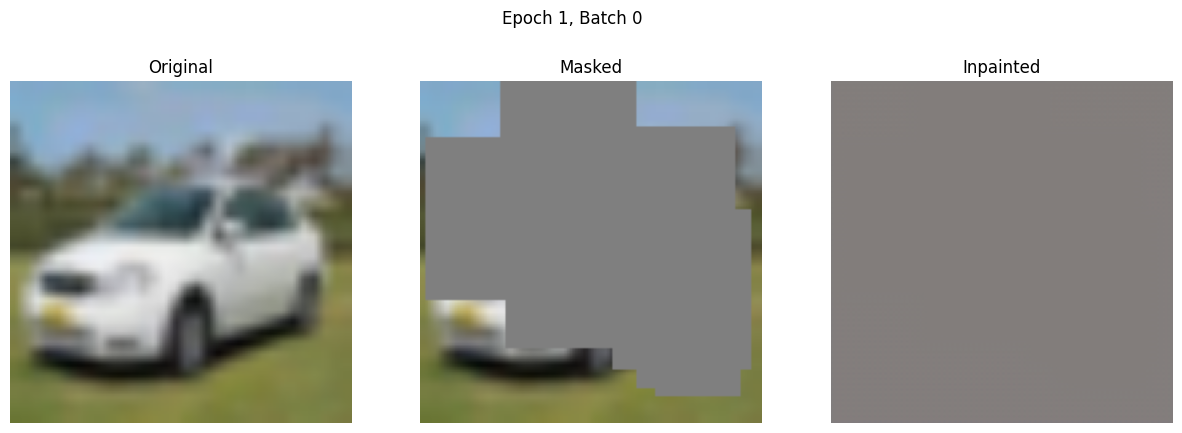

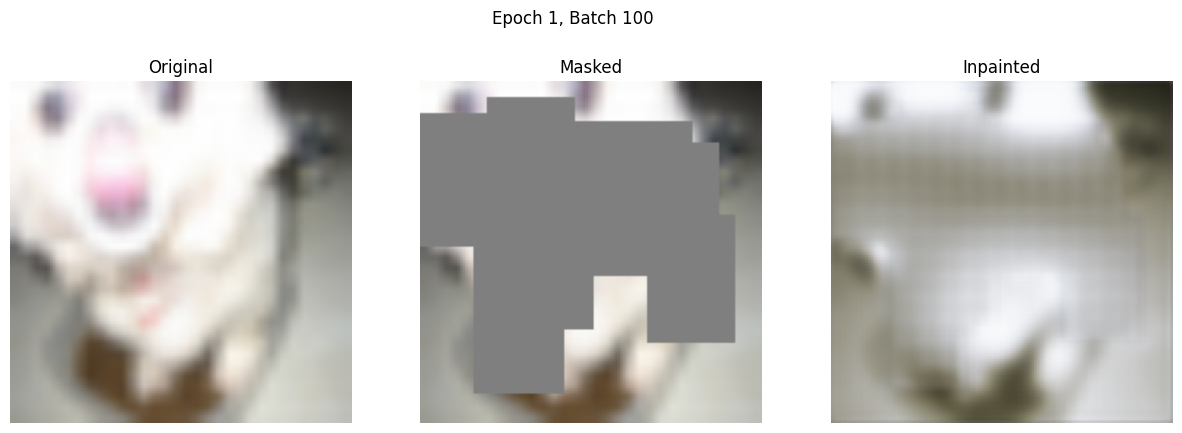

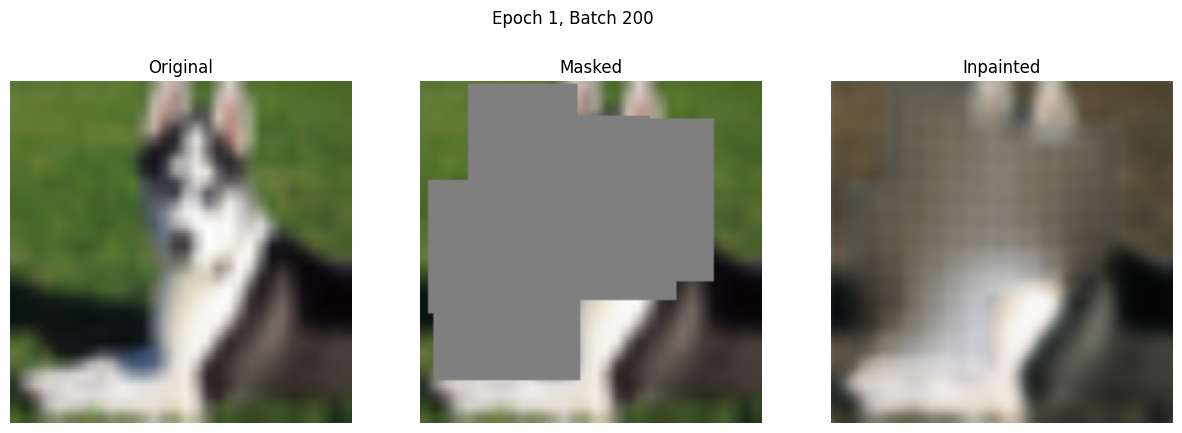

KeyboardInterrupt: 

In [42]:
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load data
    train_loader, val_loader, test_loader = setup_data(img_size=128, batch_size=32)

    # Create and train model
    model = InpaintingNet()
    train_model(model, train_loader, val_loader, num_epochs=20, device=device)

    # Evaluate and visualize
    evaluate_and_visualize(model, test_loader, device)

if __name__ == "__main__":
    main()